In [2]:
import pandas as pd
from collections import Counter
import seaborn as  sns
import re
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

queries_df = pd.read_csv("Queries.csv")
print(queries_df.head())

rows, cols = queries_df.shape

# Dimensionality is the number of columns (features)
dimensionality = cols

print("\n Dimensionality of your data:", dimensionality)

                                 Top queries  Clicks  Impressions     CTR  \
0                number guessing game python    5223        14578  35.83%   
1                        thecleverprogrammer    2809         3456  81.28%   
2           python projects with source code    2077        73380   2.83%   
3  classification report in machine learning    2012         4959  40.57%   
4                      the clever programmer    1931         2528  76.38%   

   Position  
0      1.61  
1      1.02  
2      5.94  
3      1.28  
4      1.09  

 Dimensionality of your data: 5


In [3]:
# Cleaning the CTR column.
queries_df['CTR'] = queries_df['CTR'].str.rstrip('%').astype('float') / 100

In [4]:
# Function to clean and split the queries into words
def clean_and_split(query):
    words = re.findall(r'\b[a-zA-Z]+\b', query.lower())
    return words

# Split each query into words and count the frequency of each word
word_counts = Counter()
for query in queries_df['Top queries']:
    word_counts.update(clean_and_split(query))

word_freq_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Plotting the word frequencies
fig = px.bar(word_freq_df, x='Word', y='Frequency', title='Top 20 Most Common Words in Search Queries', color = 'Word')
fig = px.bar(word_freq_df, x='Word', y='Frequency', title='Top 20 Most Common Words in Search Queries', color = 'Frequency')
fig.show()

In [5]:
# Top queries by Clicks and Impressions
top_queries_clicks_vis = queries_df.nlargest(10, 'Clicks')[['Top queries', 'Clicks']]
top_queries_impressions_vis = queries_df.nlargest(10, 'Impressions')[['Top queries', 'Impressions']]

# Plotting
fig_clicks = px.bar(top_queries_clicks_vis, x='Top queries', y='Clicks', title='Top Queries by Clicks', color = 'Clicks')
fig_impressions = px.bar(top_queries_impressions_vis, x='Top queries', y='Impressions', title='Top Queries by Impressions', color = 'Impressions')
fig_clicks.show()
fig_impressions.show()

In [6]:
# Queries with highest and lowest CTR
top_ctr_vis = queries_df.nlargest(10, 'CTR')[['Top queries', 'CTR']]
bottom_ctr_vis = queries_df.nsmallest(10, 'CTR')[['Top queries', 'CTR']]

# Plotting
fig_top_ctr = px.bar(top_ctr_vis, x='Top queries', y='CTR', title='Top Queries by CTR', color = 'CTR')
fig_bottom_ctr = px.bar(bottom_ctr_vis, x='Top queries', y='CTR', title='Bottom Queries by CTR', color = 'CTR')
fig_top_ctr.show()
fig_bottom_ctr.show()

In [7]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt

# Select relevant features
svm_features = queries_df[['Clicks', 'Impressions', 'CTR', 'Position']]


# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(svm_features)  # Scale the features

# Implement One-Class SVM model
svm_model = svm.OneClassSVM(nu=0.01, kernel='rbf', gamma=0.01)

# Train the model on the scaled features
svm_model.fit(scaled_features)

# Predict outliers
predictions = svm_model.predict(scaled_features)
outliers = queries_df[predictions == -1]  # Select rows with -1 prediction (anomalies)

queries_df['anomoly'] = svm_model.predict(scaled_features)




In [8]:
# Print results
print("Total Number of normal data points:", (predictions == 1).sum())
print("Total Number of outliers:", (predictions == -1).sum())
print("The Outlier's data:")
print(outliers)


Total Number of normal data points: 991
Total Number of outliers: 9
The Outlier's data:
                          Top queries  Clicks  Impressions     CTR  Position
0         number guessing game python    5223        14578  0.3583      1.61
1                 thecleverprogrammer    2809         3456  0.8128      1.02
2    python projects with source code    2077        73380  0.0283      5.94
4               the clever programmer    1931         2528  0.7638      1.09
82                           r2 score     367        56322  0.0065      9.33
167               text to handwriting     222        11283  0.0197     28.52
858            water quality analysis      56         7359  0.0076     27.56
927         the clever programmer.com      53           64  0.8281      1.00
928          the cleverprogrammer.com      53           62  0.8548      1.00


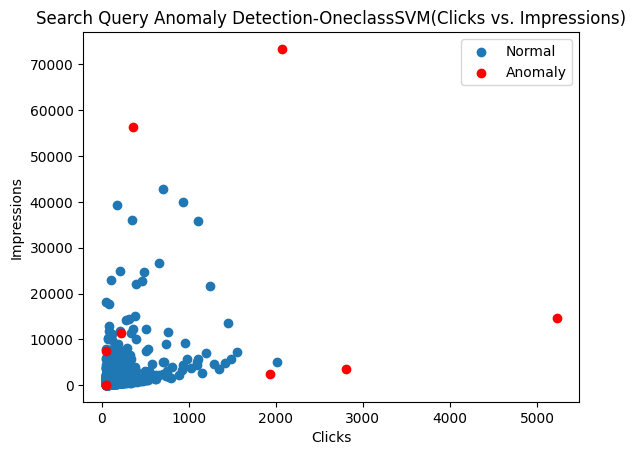

In [9]:
# Visual result
normal_data = queries_df[queries_df['anomoly'] == 1]
anomalous_data = queries_df[queries_df['anomoly'] == -1]

# Clicks vs Impression
plt.scatter(normal_data['Clicks'], normal_data['Impressions'], label='Normal')
plt.scatter(anomalous_data['Clicks'], anomalous_data['Impressions'], label='Anomaly', color='red')
plt.xlabel('Clicks')
plt.ylabel('Impressions')
plt.title('Search Query Anomaly Detection-OneclassSVM(Clicks vs. Impressions)')
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

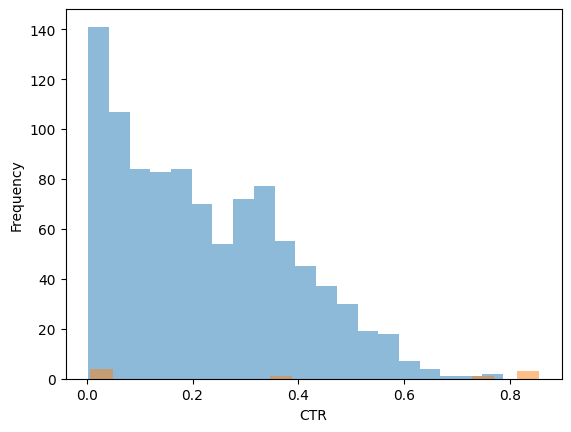

In [10]:

plt.hist(normal_data['CTR'], bins=20, label='Normal', alpha=0.5)
plt.hist(anomalous_data['CTR'], bins=20, label='Anomaly', alpha=0.5)
plt.xlabel('CTR')
plt.ylabel('Frequency')

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

# Selecting relevant features
features = queries_df[['Clicks', 'Impressions', 'CTR', 'Position']]

# Initializing Isolation Forest
iso_forest = IsolationForest(n_estimators = 100, contamination = 0.01)  # contamination is the expected proportion of outliers

# Fitting the model
iso_forest.fit(features)

# Predicting anomalies
queries_df['anomaly'] = iso_forest.predict(features)

# Filtering out the anomalies
anomalies = queries_df[queries_df['anomaly'] == -1]

# Printing the total anomalies for Isolation Forest Model.
number_of_anomalies = len(queries_df[queries_df['anomaly'] == -1])
print("Total Number of Anomalies:", number_of_anomalies)

silhouette_coeff = silhouette_score(features, iso_forest.predict(features))
print("Silhouette Coefficient:", silhouette_coeff)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Total Number of Anomalies: 10
Silhouette Coefficient: 0.8942004069302997


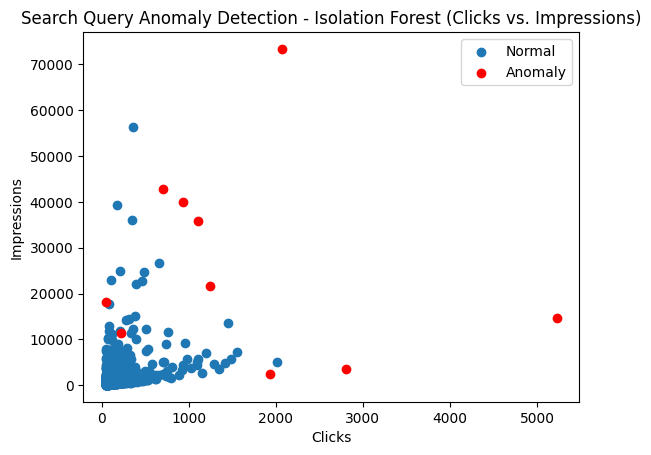

Text(0, 0.5, 'Frequency')

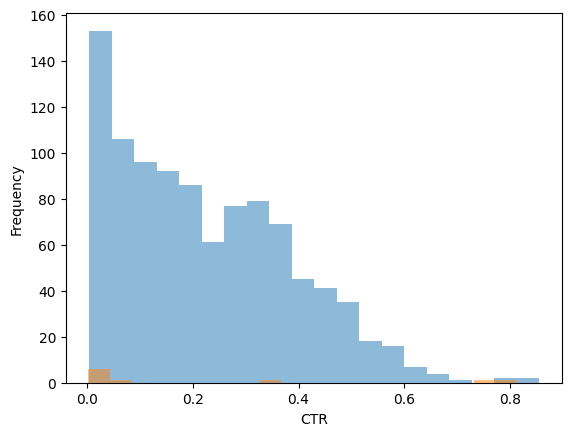

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV (assuming data is loaded elsewhere)
# queries_df = pd.read_csv("/Queries.csv")  # Uncomment if needed

# Assuming 'anomaly' column exists from training

# Visualizing normal vs. anomalous data points
normal_data = queries_df[queries_df['anomaly'] == 1]
anomalous_data = queries_df[queries_df['anomaly'] == -1]

# Scatter plot (replace features based on your choice)
plt.scatter(normal_data['Clicks'], normal_data['Impressions'], label='Normal')
plt.scatter(anomalous_data['Clicks'], anomalous_data['Impressions'], label='Anomaly', color='red')
plt.xlabel('Clicks')
plt.ylabel('Impressions')
plt.title('Search Query Anomaly Detection - Isolation Forest (Clicks vs. Impressions)')
plt.legend()
plt.show()

# Additional visualization (example - distribution of CTR for normal vs. anomalous)
plt.hist(normal_data['CTR'], bins=20, label='Normal', alpha=0.5)
plt.hist(anomalous_data['CTR'], bins=20, label='Anomaly', alpha=0.5)
plt.xlabel('CTR')
plt.ylabel('Frequency')